# MLP Visualization

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt

### Data

In [2]:
# 데이터 로드
X = torch.load('training_set_X.tensor')
y = torch.load('training_set_Y.tensor')

print("X's shape: ", X.shape)
print("y's shape: ", y.shape) # 1, 3, 4, 5, 6, 7, 8

# Dataset 만들기
dataset = TensorDataset(X, y)

# Train / validation으로 나누기
train_size = int(0.8 * len(dataset)) # train 비율: 80%
val_size = len(dataset) - train_size # valid 비율: 20%
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # 일반적으로 검증데이터의 shuffle은 False로

X's shape:  torch.Size([40133, 30, 6])
y's shape:  torch.Size([40133, 7])


### MLP Model + BN

In [3]:
# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, T, num_classes):
        super(MLP, self).__init__()
        # 총 2개의 hidden layer
        self.fc1 = nn.Linear(input_size * T, hidden_size1) # 첫 번째 은닉층
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2) # 두 번째 은닉층
        self.bn2 = nn.BatchNorm1d(hidden_size2) # MLP의 입력: ( N, D)이므로 
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(hidden_size2, num_classes) # 출력층
    
    def forward(self, x):
        # x는 (N, 30, 6)의 형태로 입력
        N, T, D = x.size() # N: 배치 크기, T: 타임스텝, D: 입력 크기
        x = x.view(N , T * D)

        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        out = self.fc3(out) # (N, C_out)
        
        out = F.softmax(out, dim=1)  # 확률 분포를 얻기 위해 softmax 적용
        return out

# Input feature의 개수를 dynamic하게 입력받기
input_size = X.shape[2]  # 입력 크기 (6개 센서 데이터)
hidden_size1 = 64  # 첫 번째 은닉층의 뉴런 개수
hidden_size2 = 32  # 두 번째 은닉층의 뉴런 개수
num_classes = y.shape[1]  # 출력 크기 (라벨 개수)
T = 30

print("Input size: ", input_size, "\nHidden size1: ", hidden_size1, "\nHidden size2: ", hidden_size2, "\nT: ", T, "\nOutput size: ", num_classes)

model = MLP(input_size, hidden_size1, hidden_size2, T, num_classes)  # instantiate


Input size:  6 
Hidden size1:  64 
Hidden size2:  32 
T:  30 
Output size:  7


### Training & Evaluation + Learning rate schedular

Epoch [10/100], Loss: -0.8102, Validation Accuracy: 77.99%
Epoch [20/100], Loss: -0.8111, Validation Accuracy: 78.05%
Epoch [30/100], Loss: -0.8108, Validation Accuracy: 78.05%
Epoch [40/100], Loss: -0.8112, Validation Accuracy: 78.10%
Epoch [50/100], Loss: -0.8112, Validation Accuracy: 78.05%
Epoch [60/100], Loss: -0.8110, Validation Accuracy: 78.07%
Epoch [70/100], Loss: -0.8112, Validation Accuracy: 78.10%
Epoch [80/100], Loss: -0.8112, Validation Accuracy: 78.10%
Epoch [90/100], Loss: -0.8115, Validation Accuracy: 78.07%
Epoch [100/100], Loss: -0.8113, Validation Accuracy: 78.07%


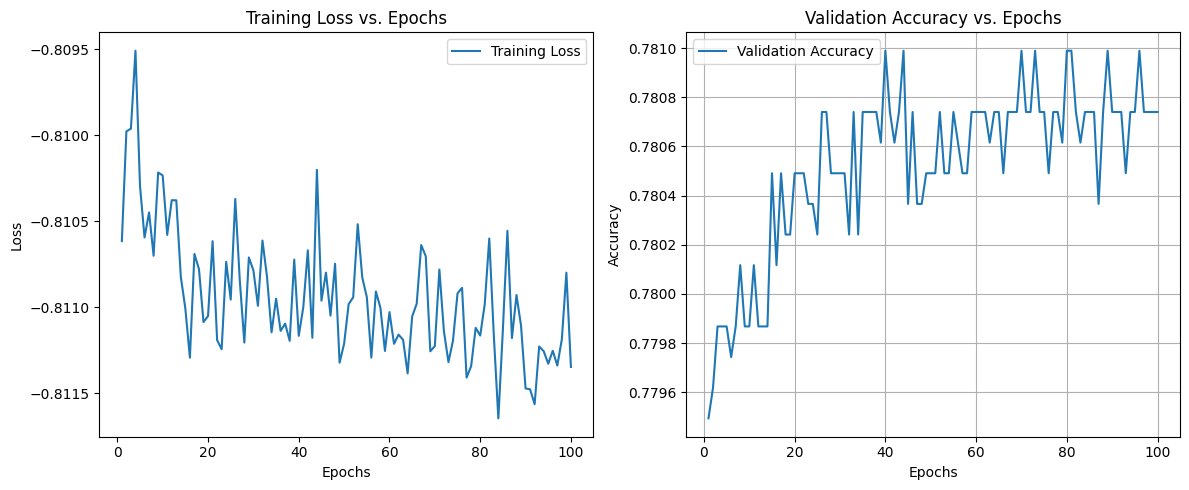

In [5]:
criterion = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

num_epochs = 100
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train() # 학습 모드
    
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X) # (N, C_out) - 주어진 T만큼의 데이터에서 다음 label 확률분포 예측
        loss = criterion(outputs, batch_y)

        # Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # learning rate 업데이트
    scheduler.step()
    
    # epoch의 loss
    train_losses.append(running_loss / len(train_loader))
    
    # Evaluation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_X, val_y in val_loader:
            outputs = model(val_X) # softmax가 적용된 상태
            _, predicted = torch.max(outputs, 1) #각 샘플의 가장 높은 값 비교하기
            
            val_total += val_y.size(0)
            val_correct += (predicted == val_y.argmax(dim=1)).sum().item() # 가장 높은 값끼리 비교
    
    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)
    
    # Loss 출력
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%')

# Matplot
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# 첫 번째 graph
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()

# 두 번째 graph
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs. Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

torch.save(model.state_dict(), 'mlp_model.pth')  # Model의 가중치 저장